# FEATURE SELECTION

In [231]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import feature_selection, preprocessing, discriminant_analysis
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
path_rawdata    = 'F://TFG//datasets/raw_datasets//'
path_train      = 'F://TFG//datasets//data_train//'
path_graphs     = 'F://TFG//graphs//'
path            = 'F:/TFG/datasets/nature-dataset/'

In [121]:
ataque_defensa   = pd.read_csv(path_rawdata+'indicador_ataquedefensa_teams.csv',sep=';')
data             = pd.read_csv(path_rawdata+'matches_wUltPartidos.csv',sep=';',index_col='wyId')
shots            = pd.read_json(path_rawdata + 'shots.json')
passes           = pd.read_json(path_rawdata + 'passes.json')
data.head(3)

,dateutc,competitionId,seasonId,roundId,winner,teamId_home,score_home,scoreHT_home,teamId_away,score_away,...,passes_acc_11H,passes_acc_11A,keyPasses_H,keyPasses_A,ataque_h,defensa_h,ataque_a,defensa_a,ataquedefensa_H,ataquedefensa_A
wyId,,,,,,,,,,,,,,,,,,,,,
2499738,2018-03-31 14:00:00,364,181150,4405654,1633,1633,3,3,1619,0,...,0.757778,0.782137,5,6,0.76,1.72,0.96,2.24,0.973546,0.817933
2499799,2017-10-21 11:30:00,364,181150,4405654,1610,1610,4,1,1644,2,...,0.851005,0.843464,4,8,0.56,0.84,2.00,1.20,1.316667,0.810784
2499800,2017-10-22 12:30:00,364,181150,4405654,1609,1623,2,1,1609,5,...,0.836437,0.858100,16,7,0.60,1.20,0.48,1.72,0.983333,1.399187


Este es el dataset base sobre el cual haremos un analisis de características. Las características se dividen en diferentes tipos:
- **Características propias del partido (lo identifican)**<br>
       ['matchId', 'dateutc', 'competitionId', 'seasonId', 'roundId', 'winner',
       'teamId_home', 'score_home', 'scoreHT_home', 'teamId_away',
       'score_away', 'scoreHT_away']


- **Estadísticas del partido**: p.e. goles, faltas, corners... Las usaremos para visualizar y ver si hay dependencia con el resultado<br>
       ['HS', 'AS', 'HST', 'AST', 'HC', 'AC',
       'HF', 'AF']


- **Cuotas de Cassas de Apuestas**: usadas en el Baseline<br> ['B365H', 'B365D', 'B365A']


- **Más estadísticas**: Las usaremos para visualizar y ver si hay dependencia con el resultado <br>
       ['y0_sh_H', 'x0_sh_H',
       'acc_avg_sh_H', 'goal_avg_sh_H', 'y0_sh_A', 'x0_sh_A', 'acc_avg_sh_A',
       'goal_avg_sh_A', 'y0_ps_H', 'x0_ps_H', 'y1_ps_H',
       'x1_ps_H', 'acc_avg_ps_H', 'keypass_ps_H', 'y0_ps_A', 'x0_ps_A',
       'y1_ps_A', 'x1_ps_A', 'acc_avg_ps_A', 'keypass_ps_A']

       
- **Estadísticas del 11 titular los ultimos N partidos**: usadas para el modelo de predicción<br>
       ['mins4_H', 'mins4_A', 'shots_11H',
       'shots_11A', 'shots_acc_11H', 'shots_acc_11A', 'goals_H', 'goals_A',
       'passes_11H', 'passes_11A', 'passes_acc_11H', 'passes_acc_11A',
       'keyPasses_H', 'keyPasses_A']

- **Rating del equipo**: define la forma y rating del equipo. Los 4 primeros definen el estado de forma en ataque y defensa del equipo en los ultimos 4 partidos, y los ultimos dos indicadores definen el rating del equipo durante la temporada.<br>
       ['ataque_h, 'defensa_h', 'ataque_a', 'defensa_a', 'ataquedefensa_H, 'ataquedefensa_A']

### PREPROCESAMIENTO DEL DATASET

Ligeros cambios para visualizar y analizar los datos de los que disponemos.

In [122]:
target = []

for match in data.itertuples():
    if match.winner == 0: target.append(0)
    elif match.winner == match.teamId_home: target.append(1)
    else: target.append(2)

data['res'] = target

## ANALISIS Y VISUALIZACIÓN

## Estadísticas del partido

#### Distribución de los resultados

Importante también visualizar separando las diferentes competiciones, para ver si siguen las mismas distribuciones o no.

También buena idea visualizar dependiendo el nivel de los clubes. Para ello podemos hacer clusters de los equipos según las características (goles marcados y encajados por ejemplo)

In [38]:
print('La distribución de victorias locales, empates y victores visitantes es la siguiente:')
clases = ['Empate','Victorias locales','Victorias visitantes']
for clase,count in zip(clases,np.bincount(data.res)):
    print(f'{clase}: {count}')

La distribución de victorias locales, empates y victores visitantes es la siguiente:
Empate: 357
Victorias locales: 652
Victorias visitantes: 425


#### Distribución de los goles

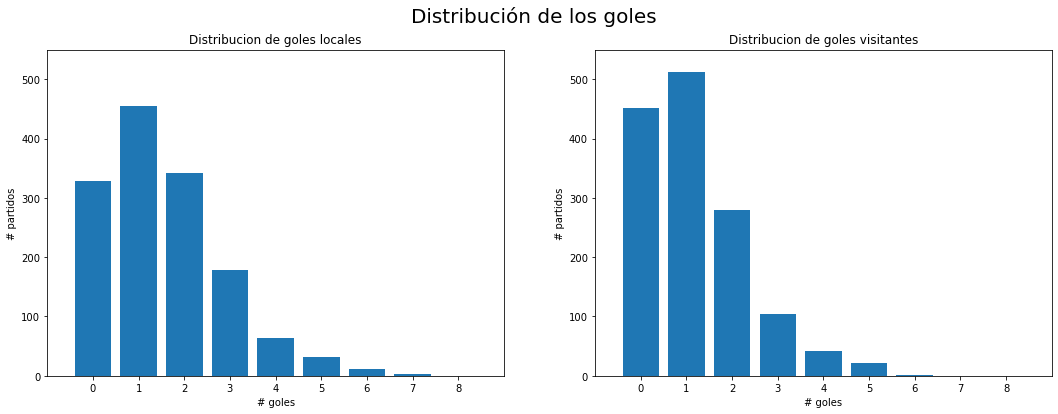

In [252]:
fig, axs = plt.subplots(1,2,figsize=(18,6))

fig.suptitle('Distribución de los goles', fontsize=20)

axs[0].set_title('Distribucion de goles locales')
axs[1].set_title('Distribucion de goles visitantes')

max_value = max(np.concatenate([data.score_home, data.score_away]))

idxs = ['score_home','score_away']
for i,ax in zip(idxs,axs):
    x = data[i]
    ax.hist(x,bins=np.arange(max_value+1)-0.5,rwidth=0.8,align='mid')
    ax.set_ylim(0,550)
    ax.set_xlim([-1,max_value+1])
    ax.set_xticks(range(max_value+1))
    ax.set_xlabel('# goles')
    ax.set_ylabel('# partidos')

# plt.savefig(path_graphs + 'goals_distribution.pdf', format='pdf')
plt.savefig(path_graphs + 'goals_distribution.jpg', format='jpg', dpi=200)

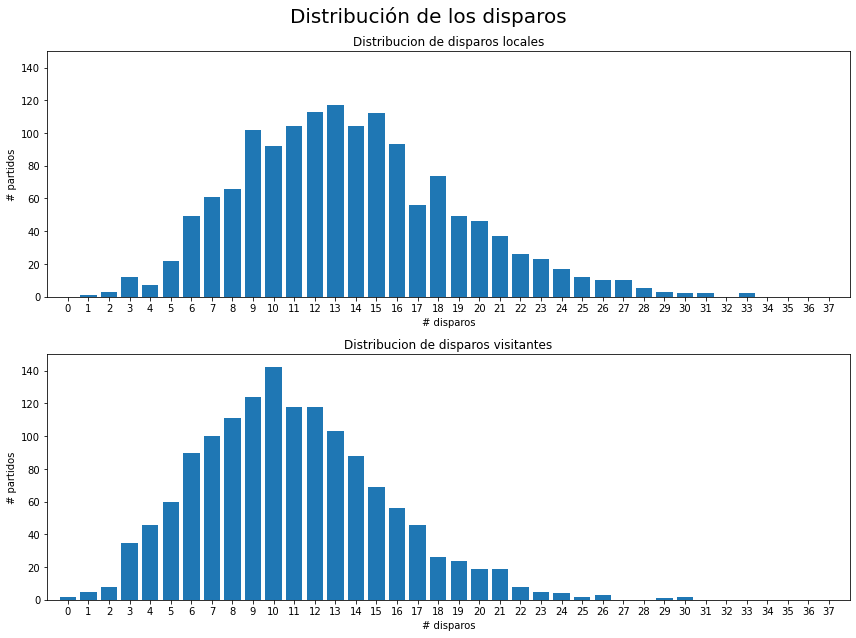

In [40]:
fig, axs = plt.subplots(2,1,figsize=(12,9))

fig.suptitle('Distribución de los disparos', fontsize=20)

axs[0].set_title('Distribucion de disparos locales')
axs[1].set_title('Distribucion de disparos visitantes')

max_value = max(np.concatenate([data.HS, data.AS]))

idxs = ['HS','AS']
for i,ax in zip(idxs,axs):
    x = data[i]
    ax.hist(x,bins=np.arange(max_value+1)-0.5,rwidth=0.8,align='mid')
    ax.set_ylim(0,150)
    ax.set_xlim([-1,max_value+1])
    ax.set_xticks(range(max_value+1))
    ax.set_xlabel('# disparos')
    ax.set_ylabel('# partidos')
    # ax.grid()

fig.tight_layout()

# plt.savefig(path_graphs + 'goals_distribution.pdf', format='pdf')
plt.savefig(path_graphs + 'shots_distribution.jpg', format='jpg', dpi=200)

In [41]:
mean_HS = np.mean(data.HS)
std_HS  = np.std(data.HS)
mean_AS = np.mean(data.AS)
std_AS  = np.std(data.AS)

print(f"Los disparos locales siguen una distribución Normal con \u03BC={mean_HS} y \u03C3={std_HS}.")
print(f"Los disparos visitantes siguen una distribución Normal con \u03BC={mean_AS} y \u03C3={mean_AS}.")

Los disparos locales siguen una distribución Normal con μ=13.705020920502092 y σ=5.257539173941706.
Los disparos visitantes siguen una distribución Normal con μ=10.864016736401673 y σ=10.864016736401673.


QQ-plot

Visualizar:
- distribución de disparos del equipo que gana
- distribucion de disparos del equipo que pierde
- distribucion de la zona del campo de los disparos (total, local y visitante)
- distribucion de la zona del campo de los pases (total, local y visitante)
- Zona del campo en la que hace los pases el equipo ganador y perdedor (heatmap) [necesario el dataset de pases]
- Zona del campo en la que dispara el equipo ganador y perdedor (heatmap) [necesario el dataset de disparos]
- Probabilidad de que el equipo más acertado cara a puerta gana el partido
- Probabilidad de que el equipo más acertado en pases gana el partido

#### Distribucion de disparos del equipo que gana y del que pierde


In [42]:
# distribucion de disparos del equipo que gana y del que pierde

num_shots = shots.set_index(['teamId','matchId']).groupby(['teamId','matchId']).agg(shots=('id','count')).reset_index()
num_shots.columns

Index(['teamId', 'matchId', 'shots'], dtype='object')

In [43]:
winner_ids, match_ids = (list(data[data.winner!=0].winner), list(data[data.winner!=0].matchId))

In [44]:
winners_match = pd.DataFrame({'teamId':winner_ids, 'matchId':match_ids})
winners_match.columns

Index(['teamId', 'matchId'], dtype='object')

In [45]:
winner_shots = pd.merge(winners_match,num_shots, on=['teamId','matchId'], how='inner')
winner_shots

,teamId,matchId,shots
0,3161,2576335,14
1,3158,2576336,15
2,3173,2576329,6
3,3165,2576330,6
4,3163,2576331,17
...,...,...,...
1072,676,2565629,11
1073,674,2565632,16
1074,684,2565634,10
1075,682,2565618,10


In [46]:
assert np.unique(winner_shots.matchId).shape[0] == len(match_ids)

In [47]:
pierde_h, matches_pierde_h = data[data.res == 2].teamId_home, data[data.res == 2].matchId         # cogemos el contrario -> si gana visitante (2) cogemos el local
pierde_a, matches_pierde_a = data[data.res == 1].teamId_away, data[data.res == 1].matchId

pierde = np.concatenate([pierde_h,pierde_a])
matches_pierde = np.concatenate([matches_pierde_h, matches_pierde_a])

In [48]:
losers_match = pd.DataFrame({'teamId':pierde, 'matchId':matches_pierde})
losers_match.columns

Index(['teamId', 'matchId'], dtype='object')

In [49]:
loser_shots = pd.merge(losers_match,num_shots, on=['teamId','matchId'], how='inner')
loser_shots

,teamId,matchId,shots
0,3162,2576335,14
1,3315,2576336,14
2,3193,2576338,11
3,3164,2576325,8
4,3176,2576319,13
...,...,...,...
1070,701,2565633,10
1071,678,2565635,7
1072,683,2565629,12
1073,680,2565632,15


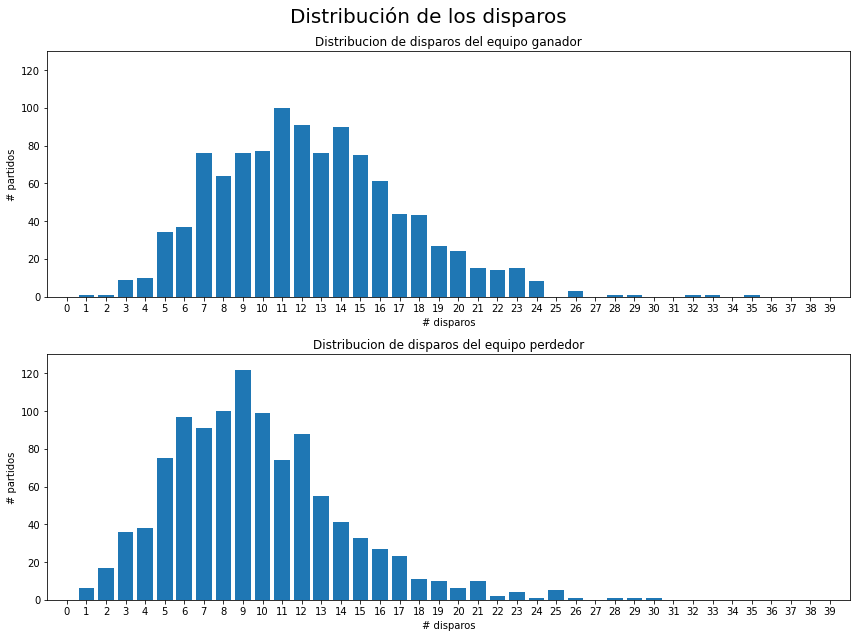

In [251]:
fig, axs = plt.subplots(2,1,figsize=(12,9))

fig.suptitle('Distribución de los disparos', fontsize=20)

axs[0].set_title('Distribucion de disparos del equipo ganador')
axs[1].set_title('Distribucion de disparos del equipo perdedor')

max_value = max(np.concatenate([winner_shots.shots, loser_shots.shots]))

# idxs = ['HS','AS']
x = [winner_shots.shots,loser_shots.shots]

for i,ax in enumerate(axs):
    ax.hist(x[i],bins=np.arange(max_value+1)-0.5,rwidth=0.8,align='mid')
    ax.set_ylim(0,130)
    ax.set_xlim([-1,max_value+1])
    ax.set_xticks(range(max_value+1))
    ax.set_xlabel('# disparos')
    ax.set_ylabel('# partidos')
    # ax.grid()

fig.tight_layout()

# plt.savefig(path_graphs + 'goals_distribution.pdf', format='pdf')
plt.savefig(path_graphs + 'shots_distribution_winner_losers.jpg', format='jpg', dpi=200)

#### Relacion de los disparos del equipo ganador y perdedor con el resultado del partido

In [64]:
res = data[['res','matchId']]
res

,res,matchId
wyId,,
2576335,2,2576335
2576336,2,2576336
2576329,1,2576329
2576330,1,2576330
2576331,1,2576331
...,...,...
2565632,1,2565632
2565634,1,2565634
2565628,0,2565628


In [65]:
x = pd.merge(winner_shots,loser_shots,on='matchId', suffixes=['_win','_los'])
x = pd.merge(x,res,on='matchId')
x


,teamId_win,matchId,shots_win,teamId_los,shots_los,res
0,3161,2576335,14,3162,14,2
1,3158,2576336,15,3315,14,2
2,3173,2576329,6,3172,11,1
3,3165,2576330,6,3219,10,1
4,3163,2576331,17,3166,8,1
...,...,...,...,...,...,...
1070,676,2565629,11,683,12,1
1071,674,2565632,16,680,15,1
1072,684,2565634,10,696,5,1
1073,682,2565618,10,756,23,2


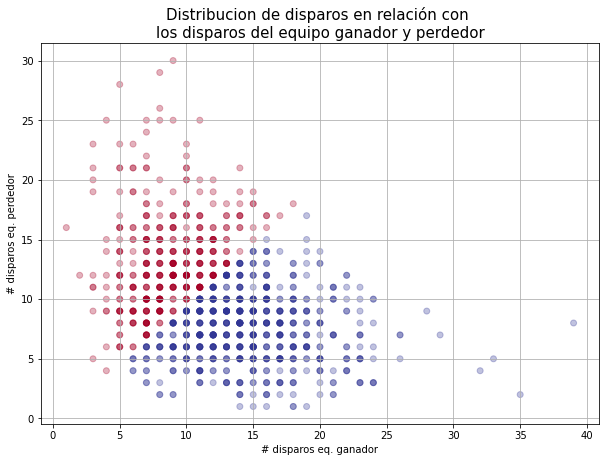

In [66]:
plt.figure(figsize=(10,7))
plt.grid()
plt.title('Distribucion de disparos en relación con \nlos disparos del equipo ganador y perdedor', fontsize=15)
plt.xlabel('# disparos eq. ganador')
plt.ylabel('# disparos eq. perdedor')
plt.scatter(x=x.shots_win, y=x.shots_los,c=(x.shots_win > x.shots_los),cmap='RdYlBu',alpha=0.3)
# plt.xlim, plt.ylim = (0,40), (0,40)

plt.savefig(path_graphs + 'shots_winloss_dist.jpg', format='jpg', dpi=200)

Cual es la probabilidad de que un equipo que ha realizado más disparos pierda un partido?

In [67]:
np.mean(x.shots_win < x.shots_los)

0.3227906976744186

El **32%** de los partidos los gana el equipo que menos disparos ha realizado.

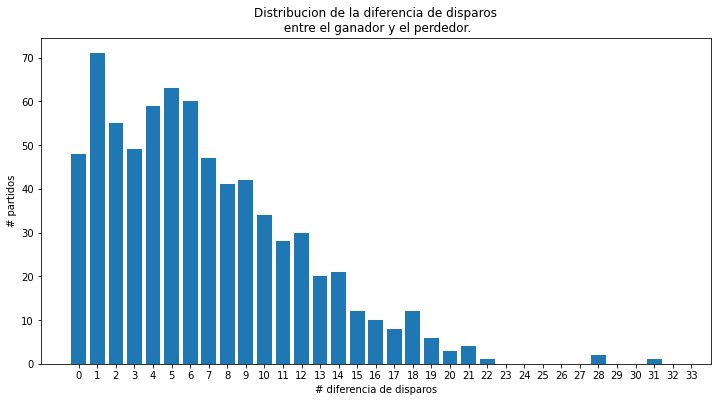

In [68]:
max_value = max(x.shots_win-x.shots_los)
plt.figure(figsize=(12,6))
plt.xticks(range(max_value+1))
plt.hist(x.shots_win-x.shots_los, bins=np.arange(max_value+1)-0.5, rwidth=0.8, align='mid')
plt.ylim = (0,80)
plt.xlim = ([-1,max_value+1])

plt.title('Distribucion de la diferencia de disparos\n entre el ganador y el perdedor.')
plt.xlabel('# diferencia de disparos')
plt.ylabel('# partidos')
# plt.grid()

plt.savefig(path_graphs + 'dif_shots_winlos.jpg', format='jpg', dpi=200)

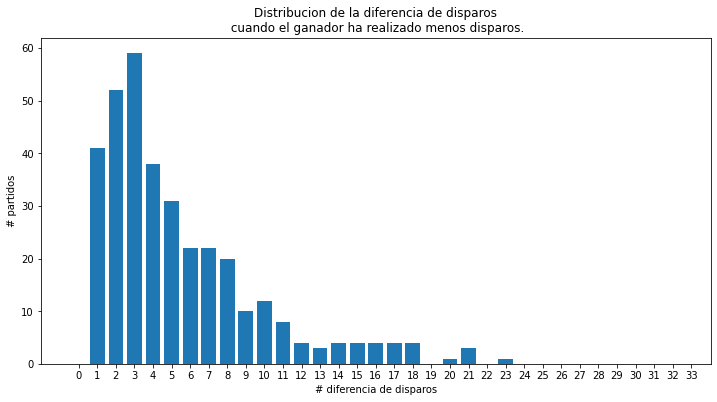

In [69]:
max_value = max(x[x.res==1].shots_win-x[x.res==1].shots_los)
mask = x.shots_win < x.shots_los
plt.figure(figsize=(12,6))
plt.xticks(range(max_value+1))
plt.hist(x[mask].shots_los-x[mask].shots_win, bins=np.arange(max_value+1)-0.5, rwidth=0.8, align='mid')
plt.ylim = (0,80)
plt.xlim = ([-1,max_value+1])

plt.title('Distribucion de la diferencia de disparos\n cuando el ganador ha realizado menos disparos.')
plt.xlabel('# diferencia de disparos')
plt.ylabel('# partidos')
# plt.grid()

plt.savefig(path_graphs + 'dif_shots_los_mas_disparos.jpg', format='jpg', dpi=200)

#### Acierto en el disparo y en el pase en relación con el numero de partidos ganados.

In [13]:
teams = pd.read_csv(path_rawdata+'teams.csv',index_col='wyId',delimiter=';')

In [14]:
acc_shots_teams = shots.groupby('teamId').agg(accuracy=('accuracy','mean')).sort_values('accuracy',ascending=False)
acc_passes_teams = passes.groupby('teamId').agg(accuracy=('accuracy','mean')).sort_values('accuracy',ascending=False)

In [15]:
acc_shots_teams_names = acc_shots_teams.join(teams)[['name','accuracy']]
acc_shots_teams_names['index'] = range(1,len(acc_shots_teams_names)+1)
acc_shots_teams_names.set_index('index',inplace=True)

acc_passes_teams_names = acc_passes_teams.join(teams)[['name','accuracy']]
acc_passes_teams_names['index'] = range(1,len(acc_passes_teams_names)+1)
acc_passes_teams_names.set_index('index',inplace=True)

In [71]:
acc_shots_teams_names[:10], acc_shots_teams_names[-10:]

(                       name  accuracy
 index                                
 1                 Barcelona  0.476096
 2                Hertha BSC  0.437931
 3                       PSG  0.417563
 4                Real Betis  0.415042
 5           Manchester City  0.414594
 6               Real Madrid  0.412044
 7                Schalke 04  0.410765
 8        Olympique Lyonnais  0.406746
 9                   Arsenal  0.403346
 10     Atl\u00e9tico Madrid  0.401130,
                        name  accuracy
 index                                
 89                  Watford  0.307882
 90     West Bromwich Albion  0.304843
 91                  Levante  0.303977
 92                     SPAL  0.302395
 93               Strasbourg  0.300248
 94                 Sassuolo  0.296729
 95                Amiens SC  0.292308
 96                   Nantes  0.281755
 97            Hellas Verona  0.281150
 98                     Caen  0.276699)

In [70]:
acc_passes_teams_names[:10], acc_passes_teams_names[-10:]

(                      name  accuracy
 index                               
 1          Manchester City  0.899866
 2                      PSG  0.892463
 3                     Nice  0.886754
 4                Barcelona  0.885168
 5                 Juventus  0.884102
 6      Bayern M\u00fcnchen  0.881899
 7                   Napoli  0.881782
 8              Real Madrid  0.881437
 9               Real Betis  0.866870
 10      Olympique Lyonnais  0.866804,
                         name  accuracy
 index                                 
 89                  Sassuolo  0.780407
 90              Hamburger SV  0.779338
 91                   Burnley  0.777125
 92     Deportivo Alav\u00e9s  0.776339
 93      West Bromwich Albion  0.776100
 94              Legan\u00e9s  0.775907
 95                Stoke City  0.772087
 96                  Augsburg  0.771405
 97                   Crotone  0.758714
 98                    Getafe  0.729798)

#### Relacion entre la media de goles encajados y marcados por un equipo

Vamos a plotear el indicador ataque-defensa de ambos equipos respecto al resultado final del partido.

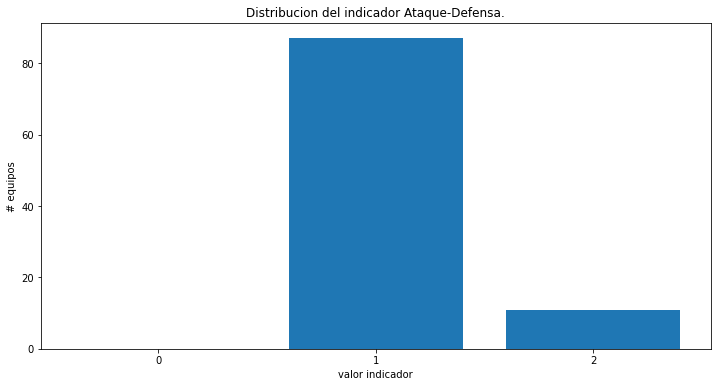

In [124]:
x = ataque_defensa.indicador

max_value = int(max(x))+1
min_value = int(min(x))
plt.figure(figsize=(12,6))
plt.xticks(range(min_value,max_value+1))
plt.hist(x, bins=np.arange(min_value,max_value+1)-0.5, rwidth=0.8, align='mid')
plt.ylim = (0,20)
plt.xlim = ([min_value,max_value+1])

plt.title('Distribucion del indicador Ataque-Defensa.')
plt.xlabel('valor indicador')
plt.ylabel('# equipos')
# plt.grid()

plt.savefig(path_graphs + 'dist_ataquedefensa.jpg', format='jpg', dpi=200)

In [90]:
x = x.ataque_defensa_h

max_value = max(x)
min_value = min(x)
plt.figure(figsize=(12,6))
plt.xticks(np.arange(int(min_value),int(max_value)+2,step=0.5))
plt.hist(x, bins=np.arange(int(min_value),int(max_value)+2,step=0.25)-0.25, rwidth=0.8, align='mid')
plt.ylim = (0,250)
plt.xlim = ([int(min_value),int(max_value)+2])

plt.title('Distribucion del indicador Ataque-Defensa.')
plt.xlabel('valor indicador')
plt.ylabel('# equipos')
# plt.grid()

plt.savefig(path_graphs + 'dist_ataquedefensa.jpg', format='jpg', dpi=200)

AttributeError: 'Series' object has no attribute 'ataque_defensa_h'

In [ ]:
x = data[['res','ataque_defensa_season_h','ataque_defensa_season_a']]

In [ ]:
plt.figure(figsize=(15,10))
# plt.grid()
plt.title('Relacion entre el resultado y el indicador Ataque-Defensa de la temporada', fontsize=15)
plt.xlabel('Ataque-Defensa local')
plt.ylabel('Ataque-Defensa visitante')
plt.scatter(x=x.ataque_defensa_season_h, y=x.ataque_defensa_season_a,c=x.res,cmap='Dark2_r',alpha=0.4)
# plt.xlim, plt.ylim = (0,40), (0,40)

plt.savefig(path_graphs + 'dist_res_ataquedefensa.jpg', format='jpg', dpi=200)

In [ ]:
x = data[['res','ataque_defensa_h','ataque_defensa_a']]

plt.figure(figsize=(15,10))
# plt.grid()
plt.title('Relacion entre el resultado y el indicador Ataque-Defensa de los ultimos 4 partidos', fontsize=15)
plt.xlabel('Ataque-Defensa local')
plt.ylabel('Ataque-Defensa visitante')
plt.scatter(x=x.ataque_defensa_h, y=x.ataque_defensa_a,c=x.res,cmap='Dark2_r',alpha=0.4)
# plt.xlim, plt.ylim = (0,40), (0,40)

plt.savefig(path_graphs + 'dist_res_ataquedefensa.jpg', format='jpg', dpi=200)

¿ CAMBIAR NORMALIZACIÓN ?

## Estadisticas del 11 titular

**Enlaces interesantes:**

How to Choose a Feature Selection Method For Machine Learning
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

Feature Selection Sklearn
https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

Chi-Square Test for Feature Selection in Machine learning
https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223

### Normalization



Although standardization and normalization have the same basic function, they utilize different approaches. As a result, their use cases differ as well.

Standardization is ideal for data that fits a normal/gaussian distribution.

It is also superior when handling data with outliers as it is more resistant to extreme values. Standardization is often used in PCA, where the aim is to maximize variance while reducing dimensionality.

Normalization, on the other hand, is the safer alternative when you are unsure of the distribution of your data.

All in all, determining the best feature scaling method in a machine learning task requires a strong understanding of the data being used.

In [125]:
data.columns

Index(['dateutc', 'competitionId', 'seasonId', 'roundId', 'winner',
       'teamId_home', 'score_home', 'scoreHT_home', 'teamId_away',
       'score_away', 'scoreHT_away', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC',
       'HF', 'AF', 'B365H', 'B365D', 'B365A', 'y0_sh_H', 'x0_sh_H',
       'acc_avg_sh_H', 'goal_avg_sh_H', 'y0_sh_A', 'x0_sh_A', 'acc_avg_sh_A',
       'goal_avg_sh_A', 'mins4_H', 'mins4_A', 'shots_11H', 'shots_11A',
       'shots_acc_11H', 'shots_acc_11A', 'goals_H', 'goals_A', 'goals_ratio_H',
       'goals_ratio_A', 'passes_11H', 'passes_11A', 'passes_acc_11H',
       'passes_acc_11A', 'keyPasses_H', 'keyPasses_A', 'ataque_h', 'defensa_h',
       'ataque_a', 'defensa_a', 'ataquedefensa_H', 'ataquedefensa_A', 'res'],
      dtype='object')

In [189]:
features = np.array(['mins4_H', 'mins4_A', 'shots_11H', 'shots_11A',
       'shots_acc_11H', 'shots_acc_11A', 'goals_H', 'goals_A', 'goals_ratio_H',
       'goals_ratio_A', 'passes_11H', 'passes_11A', 'passes_acc_11H',
       'passes_acc_11A', 'keyPasses_H', 'keyPasses_A', 'ataque_h', 'defensa_h',
       'ataque_a', 'defensa_a', 'ataquedefensa_H', 'ataquedefensa_A'])

# features = features[:-4] # de momento descartamos ataque_defensa

X = data[features] # descartamos de momento las de ataque_defensa

X.head(5)

,mins4_H,mins4_A,shots_11H,shots_11A,shots_acc_11H,shots_acc_11A,goals_H,goals_A,goals_ratio_H,goals_ratio_A,...,passes_acc_11H,passes_acc_11A,keyPasses_H,keyPasses_A,ataque_h,defensa_h,ataque_a,defensa_a,ataquedefensa_H,ataquedefensa_A
wyId,,,,,,,,,,,,,,,,,,,,,
2499738,60.818182,56.840909,28,18,0.321429,0.444444,1,3,0.250000,0.500000,...,0.757778,0.782137,5,6,0.76,1.72,0.96,2.24,0.973546,0.817933
2499799,54.500000,72.454545,35,28,0.400000,0.321429,4,5,1.000000,0.625000,...,0.851005,0.843464,4,8,0.56,0.84,2.00,1.20,1.316667,0.810784
2499800,63.295455,72.000000,37,29,0.162162,0.344828,1,1,0.333333,1.000000,...,0.836437,0.858100,16,7,0.60,1.20,0.48,1.72,0.983333,1.399187
2499801,42.000000,54.272727,28,22,0.392857,0.409091,2,4,1.000000,0.571429,...,0.785348,0.842152,8,3,0.36,2.16,1.04,0.32,0.689456,1.360256
2499802,63.659091,51.477273,47,25,0.510638,0.480000,10,4,0.555556,0.666667,...,0.904959,0.763764,15,2,5.48,1.08,1.24,0.64,1.935507,0.921212


Seria interesante analizar las características de cada partido (para el partido X, los corners, faltas, goles, disparos en X). Y más tarde en la selección de características usar solo la información de partidos anteriores, que realmente será la que se use en el modelo predictivo.

In [190]:
# eliminamos las filas con valores nulos

X.dropna().shape # no hay ninguna fila que eliminar

labels = data.res

In [247]:
# necesario NORMALIZAR ???
# normalization / minmax scale / other ???
# normalizamos dividiendo cada feature por su media

# # Normalizamos dividiendo entre la media.
X_mean = X.mean(axis=0).to_numpy()
X_norm = X / X_mean

# # Normalizamos con MinMaxScale
# scaler = preprocessing.MinMaxScaler()
# X_norm = scaler.fit_transform(X)
# # ¿ este normaliza todas las varianzas ? Si, es así, para la selección
# # de características a partir de la varianza no sirve.


In [240]:
X_norm.shape, labels.shape

((1414, 22), (1414,))

### Visualization

#### Distribucion de los minutos jugados por el 11 titular en los ultimos 4 partidos

In [249]:
X

,mins4_H,mins4_A,shots_11H,shots_11A,shots_acc_11H,shots_acc_11A,goals_H,goals_A,goals_ratio_H,goals_ratio_A,...,passes_acc_11H,passes_acc_11A,keyPasses_H,keyPasses_A,ataque_h,defensa_h,ataque_a,defensa_a,ataquedefensa_H,ataquedefensa_A
wyId,,,,,,,,,,,,,,,,,,,,,
2499738,60.818182,56.840909,28,18,0.321429,0.444444,1,3,0.250000,0.500000,...,0.757778,0.782137,5,6,0.76,1.72,0.96,2.24,0.973546,0.817933
2499799,54.500000,72.454545,35,28,0.400000,0.321429,4,5,1.000000,0.625000,...,0.851005,0.843464,4,8,0.56,0.84,2.00,1.20,1.316667,0.810784
2499800,63.295455,72.000000,37,29,0.162162,0.344828,1,1,0.333333,1.000000,...,0.836437,0.858100,16,7,0.60,1.20,0.48,1.72,0.983333,1.399187
2499801,42.000000,54.272727,28,22,0.392857,0.409091,2,4,1.000000,0.571429,...,0.785348,0.842152,8,3,0.36,2.16,1.04,0.32,0.689456,1.360256
2499802,63.659091,51.477273,47,25,0.510638,0.480000,10,4,0.555556,0.666667,...,0.904959,0.763764,15,2,5.48,1.08,1.24,0.64,1.935507,0.921212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576334,37.818182,49.068182,16,20,0.312500,0.100000,3,0,0.333333,0.000000,...,0.873267,0.823330,2,6,2.28,0.84,0.72,3.32,1.994841,0.661345
2576335,65.000000,67.386364,40,44,0.475000,0.454545,8,4,0.727273,0.666667,...,0.816073,0.833235,8,12,2.16,0.72,2.40,0.36,1.517949,1.423384
2576336,60.181818,44.568182,38,29,0.473684,0.241379,5,2,1.000000,0.400000,...,0.731343,0.837312,9,4,1.16,0.44,1.32,0.12,0.757576,1.418841


##### Distribution of minutes in previous matches of the line-up.

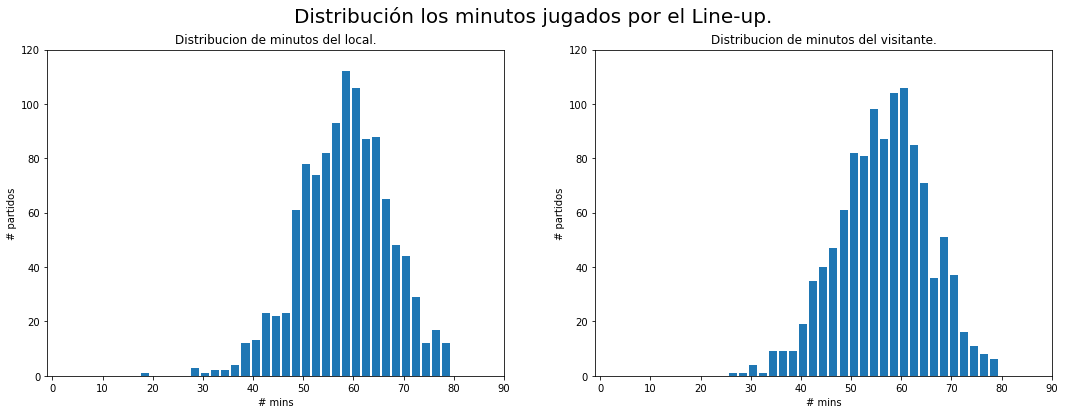

In [313]:
fig, axs = plt.subplots(1,2,figsize=(18,6))

fig.suptitle('Distribución los minutos jugados por el Line-up.', fontsize=20)

axs[0].set_title('Distribucion de minutos del local.')
axs[1].set_title('Distribucion de minutos del visitante.')

max_value = max(np.concatenate([X.mins4_H, X.mins4_A]))

idxs = ['mins4_H','mins4_A']
for i,ax in zip(idxs,axs):
    x = data[i][data[i] != 0]
    ax.hist(x,bins=np.arange(0,max_value+1,2)-0.5,rwidth=0.8,align='mid')
    ax.set_ylim(0,120)
    ax.set_xlim([-1,max_value+1])
    ax.set_xticks(range(0,91,10))
    ax.set_xlabel('# mins')
    ax.set_ylabel('# partidos')

# plt.savefig(path_graphs + 'goals_distribution.pdf', format='pdf')
plt.savefig(path_graphs + 'mins_lineup_distribution.jpg', format='jpg', dpi=200)

In [324]:
mins_norm = preprocessing.normalize(data[idxs])

In [325]:
mins_norm

array([[0.73059207, 0.68281419],
       [0.60112244, 0.79915694],
       [0.66024837, 0.75104733],
       ...,
       [0.80362708, 0.59513319],
       [0.82449352, 0.5658714 ],
       [0.64950927, 0.76035367]])

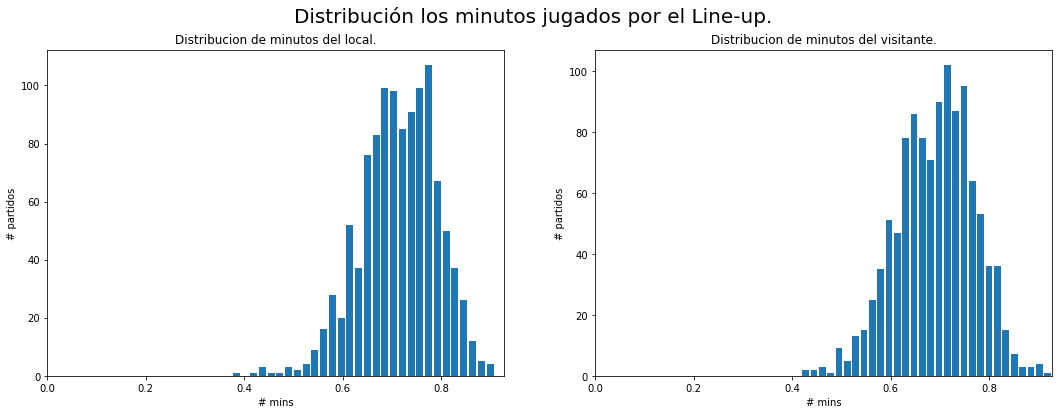

In [326]:
fig, axs = plt.subplots(1,2,figsize=(18,6))

fig.suptitle('Distribución los minutos jugados por el Line-up.', fontsize=20)

axs[0].set_title('Distribucion de minutos del local.')
axs[1].set_title('Distribucion de minutos del visitante.')

max_value = np.max(mins_norm)

# idxs = ['mins4_H','mins4_A']
for i,ax in enumerate(axs):
    x = mins_norm[:,i][mins_norm[:,i] > 0]
    ax.hist(x,bins=30,rwidth=0.8)
    # ax.set_ylim(0,120)
    ax.set_xlim([0,max_value])
    # ax.set_xticks(range(0,91,10))
    ax.set_xlabel('# mins')
    ax.set_ylabel('# partidos')

plt.savefig(path_graphs + 'mins_lineup_norm_distribution.jpg', format='jpg', dpi=200)

### Analisi Univariado


Descartamos el uso de ${\chi}^2$ por ser un test usado para inputs (variables) y outputs categóricas.

Puede ser interesante el uso de métodos de Sklearn como *SelectKBest* o *SelectPercentile*, que dados una función que puntua cada variable, selecciona las mejores variables.

#### 1. Variance Threshold

Variance is the measurement of the spread between numbers in a variable. It measures how far a number is from the mean and every number in a variable.

The variance of a feature determines how much it is impacting the response variable. If the variance is low, it implies there is no impact of this feature on response and vice-versa.

VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

In [242]:
# que valor asignar al Threshold ? Hay alguna manera de testear ? 
# Despues de normalizar las características pierden muucha varianza

filter = feature_selection.VarianceThreshold(0.25)

In [243]:
filter.fit(X_norm)

VarianceThreshold(threshold=0.25)

In [244]:
new_X = filter.transform(X_norm)
mask_new_feat = filter.get_support()
pd.DataFrame(new_X,columns=features[mask_new_feat])

,mins4_H,mins4_A,goals_H,goals_A,goals_ratio_A,keyPasses_H,keyPasses_A,ataque_h,defensa_h,ataque_a,defensa_a
0,1.319597,1.273570,0.273290,1.099533,0.901326,0.719154,1.126544,0.499953,1.458641,0.816987,1.472040
1,1.182508,1.623407,1.093158,1.832556,1.126658,0.575323,1.502058,0.368387,0.712360,1.702056,0.788593
2,1.373347,1.613223,0.273290,0.366511,1.802652,2.301292,1.314301,0.394700,1.017657,0.408493,1.130317
3,0.911291,1.216028,0.546579,1.466045,1.030087,1.150646,0.563272,0.236820,1.831782,0.885069,0.210291
4,1.381237,1.153393,2.732895,1.466045,1.201768,2.157461,0.375515,3.604928,0.915891,1.055275,0.420583
...,...,...,...,...,...,...,...,...,...,...,...
1409,0.820556,1.099415,0.819869,0.000000,0.000000,0.287661,1.126544,1.499860,0.712360,0.612740,2.181774
1410,1.410331,1.509850,2.186316,1.466045,1.201768,1.150646,2.253087,1.420920,0.610594,2.042467,0.236578
1411,1.305789,0.998589,1.366448,0.733022,0.721061,1.294477,0.751029,0.763087,0.373141,1.123357,0.078859
1412,1.312693,0.930353,0.273290,0.366511,0.901326,0.143831,0.563272,0.710460,0.712360,0.204247,1.340608


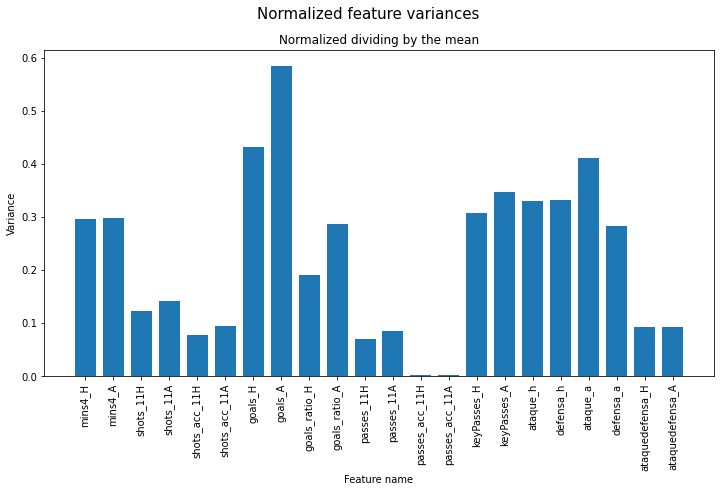

<Figure size 432x288 with 0 Axes>

In [245]:
plt.figure(figsize=(12,6))
plt.clf()
plt.bar(features, X_norm.var(), width=0.75)
plt.title("Normalized dividing by the mean")
plt.suptitle("Normalized feature variances",fontsize=15)
plt.xlabel("Feature name")
plt.ylabel("Variance")
plt.xticks(rotation=90)
plt.show()

plt.savefig(path_graphs + 'divmean_feature_variances.jpg', format='jpg', dpi=200)

In [246]:
features[mask_new_feat]

array(['mins4_H', 'mins4_A', 'goals_H', 'goals_A', 'goals_ratio_A',
       'keyPasses_H', 'keyPasses_A', 'ataque_h', 'defensa_h', 'ataque_a',
       'defensa_a'], dtype='<U15')

Estas son las características que tienen más de 0.5 de Variancia.

##### Vamos a probar con otro metodo de normalizacion.

#### 2. Ratio Dispersión (RMD)

https://en.wikipedia.org/wiki/Mean_absolute_difference#Relative_mean_absolute_difference

In [ ]:
from scipy.stats.mstats import gmean

In [ ]:
X_norm.head(3)

In [ ]:
X.goals_H.min()

In [ ]:
pd.DataFrame(gmean(X_norm).reshape(1,-1), columns=features)

#### 3. ANOVA f-test Feature Selection


https://towardsdatascience.com/anova-for-feature-selection-in-machine-learning-d9305e228476

**F-Distribution?**
A probability distribution generally used for the analysis of variance. It assumes Hypothesis as

- H0: two variances are equal
- H1: two variances are not equal

**Degrees of Freedom**
refers to the maximum number of logically independent values, which have the freedom to vary. In simple words, it can be defined as the total number of observations minus the number of independent constraints imposed on the observations.

$D_f = N-1$ where $N$ is the sample size.  

**F-value**

$s$ = variance

${\chi}^2$  = $\frac{(n-1) s^2}{\sigma^2}$

$F = \frac{\chi_1^2 / (n_1 - 1)}{\chi_2^2 / (n_2 - 1)}$

**ANOVA**

**An**alysis **o**f **Va**riance is a statistical method, used to check the means of two or more groups that are significantly different from each other. It assumes Hypothesis as
- H0: means of all groups are equal
- H1: at least one mean of the groups are different

ANOVA is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not. 

An F-statistic, or F-test, is a class of statistical tests that calculate the ratio between variances values

**The results of this test can be used for feature selection where those features that are independent of the target variable can be removed from the dataset.**

**Calculation:**

Total variance of the data.

$SST = \sum_{i}{ ( x^{(i)} - \overline{x} )^2 }$

Variance between different groups $g$.

$SSB = \sum_{g}{ ( \overline{x_g} - \overline{x} )^2 }$

Variance within each group.

$SSW = \sum_{g}[\sum_{i\in{g}}{ ( x^{(i)} - \overline{x_g} )^2 }]$

Distance between each observed value $x_g^{(i)}$ within the group $g$, with the group-mean $\overline{x_g}$

$SST = SSB + SSE$

So, the F value will be the comparison of the variance between the groups and the variance within the groups.

$F = \frac{SSB / df_b}{SSW / df_w}$

##### Calculo manual

In [ ]:
X_norm.head(3)

In [ ]:
SSB = np.sum( (np.mean(X,axis=0) - np.mean(X.to_numpy().flatten()))**2 )

In [ ]:
SSW = np.sum(np.sum( (X - np.mean(X,axis=0))**2 ))

In [ ]:
dfb, dfw = X.shape[1]-1, X.shape[0]-1
dfb,dfw

In [ ]:
F = (SSB/dfb)/(SSW/dfw) 
F

Con  95% confianza, $\alpha$ = 0.05, $df_b$ = 33 y $df_w$ = 1430, y dados que nuestro F-value de nuestra F-table es **1.4445** y nuestro F-value es **0.3539**, entonces nuestra hipótesis nula es cierta.

##### SelectKBest  $F-classif$

Habrá que entrenar con Cross Validation los hiperparámetros, en este caso para encontrar el mejor valor de $k$.

Vamos a usar *f_classif* que calcula la ANOVA F-value.

In [138]:
kbest_fclass = feature_selection.SelectKBest(score_func=feature_selection.f_classif,k=10)

In [139]:
kbest_fclass.fit(X_norm, )

ValueError: Found input variables with inconsistent numbers of samples: [1414, 1411]

In [ ]:
X_kbest = kbest_fclass.transform(X_norm)
mask_new_feat = kbest_fclass.get_support()
pd.DataFrame(X_kbest,columns=features[mask_new_feat])

In [ ]:
features[mask_new_feat]

La gran diferencia respecto a Variance Threshold es que SelectKBest selecciona como característica a tener en cuenta al *accuracy* del 11 titular en los pases. Sin embargo no tiene en cuenta los pases clave locales, solo los visitantes.

Pero repito, habria que entrenar los hiperparámetros (*k*) para obtener el numero óptimo de características.

##### SelectKBest - $\chi^2$

$\chi^2 = \sum_{i}{ \mathcal{N_i}^2}$

Una variable aleatoria $\chi$ sigue una distribucion chi-square si puede ser escrita como la suma de unas variables Normales al cuadrado.

Un test chi-square es usado en estadística para probar la independencia de dos eventos.

$\chi^2_c = \sum_{i}{\frac{(O_i - E_i)^2}{E_i}}$

$c$ = grados de libertad <br>
$O$ = valor(es) observados <br>
$E$ = valor(es) esperados

En selección de características nuestro objetivo es seleccionar las características (features) que son más dependientes en el valor de target.

Cuando dos características son independientes, el valor observado está muy próximo al esperado, por lo tanto tendremos un pequeño valor Chi-Square ($\chi^2\approx0$). Un alto valor de Chi-Square indica que la hipótesis de que las variables son independientes es incorrecta.

Las limitaciones de Chi-Square es que es muy sensible a valor pequeños.

In [ ]:
kbest_chi2 = feature_selection.SelectKBest(score_func=feature_selection.chi2,k=10)

In [ ]:
kbest_chi2.fit(X_norm, data.dropna().res)

In [ ]:
X_kbest = kbest_chi2.transform(X_norm)
mask_new_feat = kbest_chi2.get_support()
pd.DataFrame(X_kbest,columns=features[mask_new_feat])

In [ ]:
features[mask_new_feat]

In [ ]:
pvalues = -np.log10(kbest_chi2.pvalues_)
pvalues /= pvalues.max()

plt.figure(figsize=(12,6))
plt.clf()
plt.bar(features, pvalues, width=0.75)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel("P-values")
plt.xticks(rotation=90)
plt.show()

plt.savefig(path_graphs + 'feature_univariate_score_chi2.jpg', format='jpg', dpi=200)

INTERESTING: compare with weights of our model (e.g. SVM)

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

##### Mutual Information

Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances.

Comparison of F-test and mutual information¶

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py

### Analisi Multivariado

#### Linear Discriminant Analysis (LDA)

<b>En LDA se asume que las caract. o muestras son independientes?</b>

https://towardsdatascience.com/linear-discriminant-analysis-explained-f88be6c1e00b

LinearDiscriminantAnalysis can be used to perform supervised dimensionality reduction, by projecting the input data to a linear subspace consisting of the directions which maximize the separation between classes.

with $x\in\R^d$

$P(y=k | x) = \frac{P(x | y=k) P(y=k)}{P(x)} = \frac{P(x | y=k) P(y = k)}{ \sum_{l} P(x | y=l) \cdot P(y=l)}$

for linear and quadratic discriminant analysis,  is modeled as a multivariate Gaussian distribution with density:

$P(x | y=k) = \frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2}}\exp\left(-\frac{1}{2} (x-\mu_k)^t \Sigma_k^{-1} (x-\mu_k)\right)$

In LDA is a special case in which we assume to share the same covariance matrix: $\Sigma_k = \Sigma$ for all $k$.

$\log P(y=k | x) = -\frac{1}{2} (x-\mu_k)^t \Sigma^{-1} (x-\mu_k) + \log P(y = k) + Cst.$

The term $(x-\mu_k)^t \Sigma^{-1} (x-\mu_k)$ corresponds to the Mahalanobis Distance between the sample $x$ and the mean $\mu_k$. The Mahalanobis distance tells how close $x$ is from $\mu_k$, while also accounting for the variance of each feature. We can thus interpret LDA as assigning $x$ to the class whose mean is the closest in terms of Mahalanobis distance, while also accounting for the class prior probabilities.

The log-posterior of LDA can be also written as:

$\log P(y=k | x) = \omega_k^t x + \omega_{k0} + Cst.$

where $\omega_k = \Sigma^{-1} \mu_k$ and $\omega_{k0} = -\frac{1}{2} \mu_k^t\Sigma^{-1}\mu_k + \log P (y = k)$

It is clear, from the above formula, that LDA has linear decision surface.

In [ ]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(solver='eigen')

No podemos proyectar los datos a más de $k-1$ dimensiones, ya que la matrix $S_b$ (between-class matrix) tiene rango $k$.

In [ ]:
y = data.dropna().res

In [ ]:
lda.fit(X_norm,y)

In [ ]:
X_lda = lda.transform(X_norm)
X_lda.shape

In [ ]:
# plot LDA transformation

plt.figure(figsize=(15,10))
plt.title('LDA projection')
plt.xlabel('x projection')
plt.ylabel('y projection')
plt.legend(y)
plt.scatter(X_lda[:,0],X_lda[:,1],c=y,cmap='Dark2_r',alpha=0.4)

plt.savefig(path_graphs + 'lda_projection.jpg', format='jpg', dpi=200)

#### Feature Selection in Time Series

About Time Series: https://towardsdatascience.com/12-things-you-should-know-about-time-series-975a185f4eb2

##### I. Pearson's Correlation Coef VS Kolmogorov-Smirnov Test

https://towardsdatascience.com/time-series-clustering-and-dimensionality-reduction-5b3b4e84f6a3

Kolmogorov-Smirnov Test: https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

##### II. Vector Autoregression (VAR)

https://towardsdatascience.com/multiple-series-forecast-them-together-with-any-sklearn-model-96319d46269

¿How many lags to use? https://www.econometrics-with-r.org/14-6-llsuic.html

##### III. ForeCA

https://stats.stackexchange.com/questions/82291/time-series-dimensionality-reduction

#### Principal Component Analysis (PCA)

Sklearn does not implement PCA with eigen-decomposition of the Covariance matrix. However it is performed via SVD of the data matrix X.

https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

The number of Principal Components (n_comps) will be also trained as hyperparameter during Cross-Validation.